In [0]:
import cv2
import os
import time
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np

In [0]:
!git clone https://github.com/thtrieu/darkflow.git && cd darkflow && python3 setup.py build_ext --inplace && pip install -e . && pip install .
from darkflow.net.build import TFNet
clear_output()

In [0]:
# Download dataset
!wget --no-check-certificate -r 'https://docs.google.com/uc?export=download&id=18744y_Oyqtx94kpuAeEbkdFGzg9p0_5M' -O dog-breed-identification.zip
!unzip dog-breed-identification.zip 

!unzip train.zip -d ./dataset
!unzip test.zip -d ./dataset

!rm -f train.zip
!rm -f test.zip
!rm -f dog-breed-identification.zip

!mv labels.csv dataset/labels.csv
!mv sample_submission.csv dataset/sample_submission.csv

clear_output()

In [0]:
# Download model parameters
!wget --no-check-certificate -r 'https://docs.google.com/uc?export=download&id=1DMQxIlXHJchxBKf1T667B4kViHH3t5ls' -O model.zip
!unzip model.zip
!rm -f model.zip
clear_output()

In [0]:
MODEL_CFG         = 'cfg/yolo_custom.cfg'
MODEL_PB          = 'built_graph/yolo_custom.pb'
MODEL_META        = 'built_graph/yolo_custom.meta'
YOLO_WEIGHTS_PATH = 'yolo.weights'
DATASET_TEST_PATH      = 'dataset/test'

In [0]:
# draw bouning box and put label with conf. on initial image
def draw_bb(img, predict_results):
  image_with_bb = np.copy(img)
  x_1 = predict_results['topleft']['x']
  y_1 = predict_results['topleft']['y']
  x_2 = predict_results['bottomright']['x']
  y_2 = predict_results['bottomright']['y']

  confidence = predict_results['confidence']
  label = predict_results['label'] + " " + str(round(confidence, 4))
  # draw bb on image
  image_with_bb = cv2.rectangle(
      image_with_bb, 
      (x_1, y_1), 
      (x_2, y_2), 
      (255, 0, 0), 
      2
  )
  # put label and conf on image
  image_with_bb = cv2.putText(
      image_with_bb, 
      label, 
      (x_1, y_1 - 5),
      cv2.FONT_HERSHEY_COMPLEX_SMALL, 
      0.8, 
      (255, 0, 0), # color
      1, 
      cv2.LINE_AA
  )

  return image_with_bb

In [10]:
# load the model
THRESHOLD = 0.005
options = { 
        "pbLoad": './built_graph/yolo_custom.pb' ,           
        "metaLoad": './built_graph/yolo_custom.meta',
        "threshold" : THRESHOLD,
        "gpu": 1.0
}
tfnet = TFNet(options)


Loading from .pb and .meta

GPU mode with 1.0 usage






Predicted: kelpie w. conf: 0.01838727854192257; time spent: 1.2658567428588867 sec


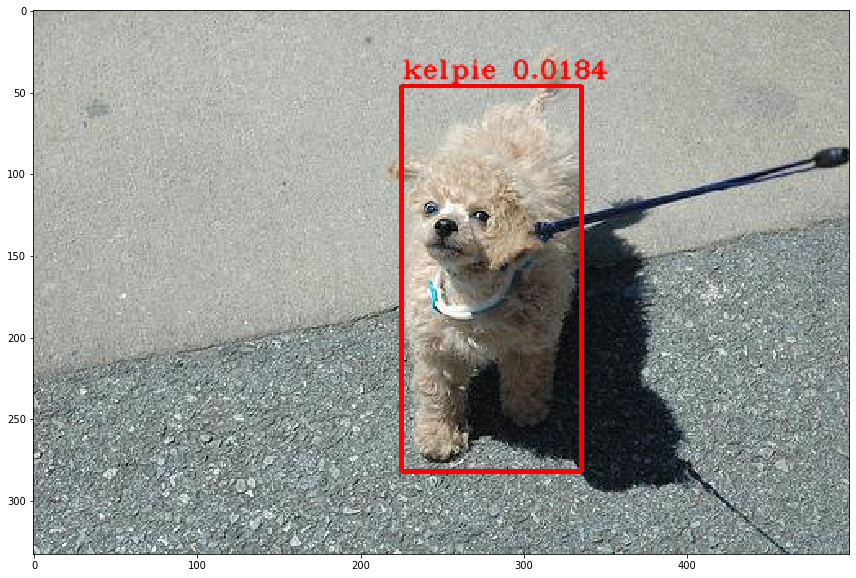

Predicted: entlebucher w. conf: 0.005050684791058302; time spent: 1.326974868774414 sec


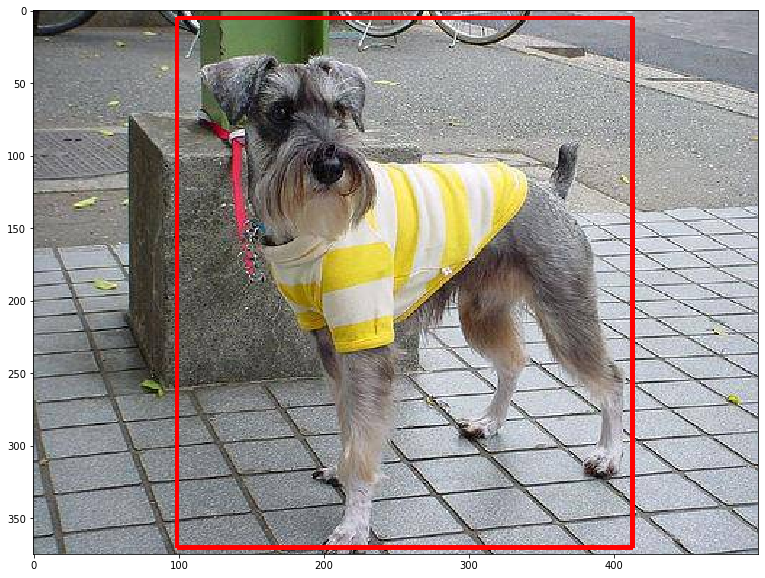

Predicted: kelpie w. conf: 0.007312624249607325; time spent: 1.3604562282562256 sec


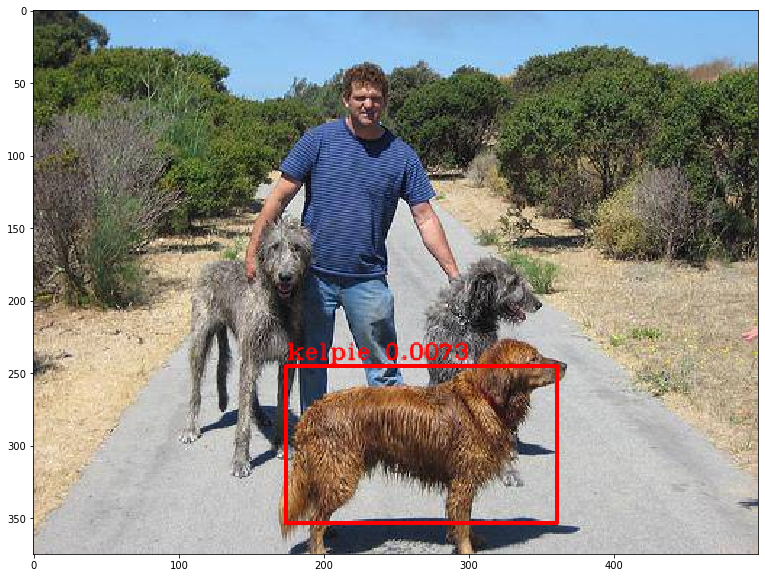

Predicted: irish_wolfhound w. conf: 0.007073903921991587; time spent: 1.4053876399993896 sec


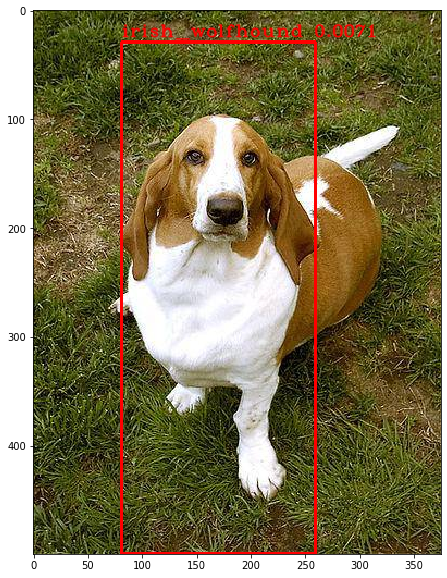

Predicted: entlebucher w. conf: 0.011214197613298893; time spent: 1.3814361095428467 sec


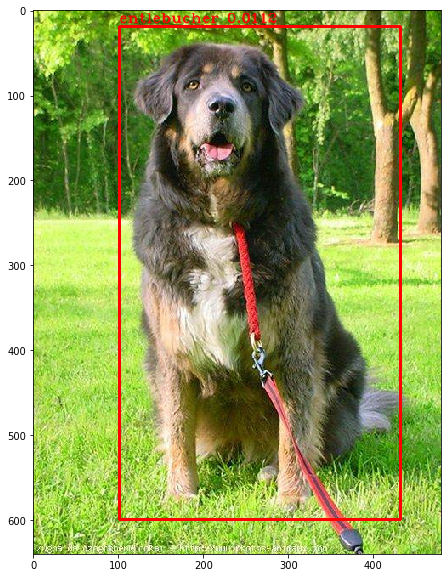

Predicted: bernese_mountain_dog w. conf: 0.006951270624995232; time spent: 1.3694469928741455 sec


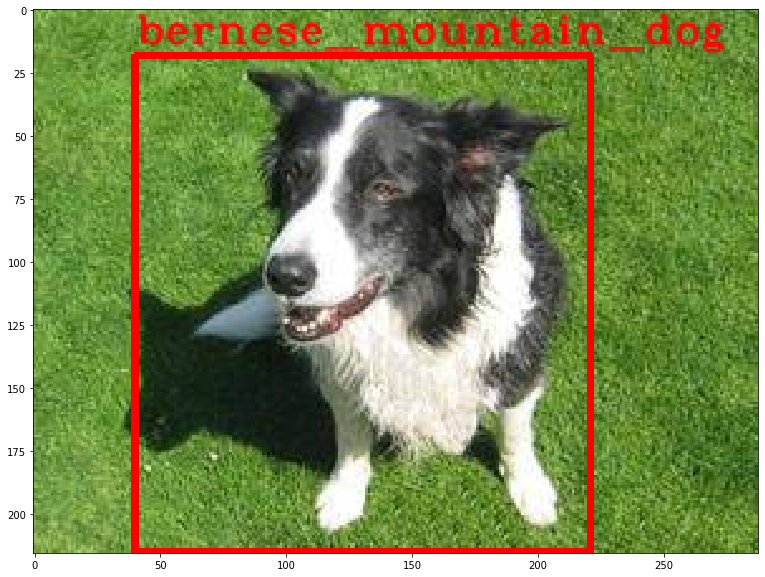

Predicted: maltese_dog w. conf: 0.00612088805064559; time spent: 1.3103091716766357 sec


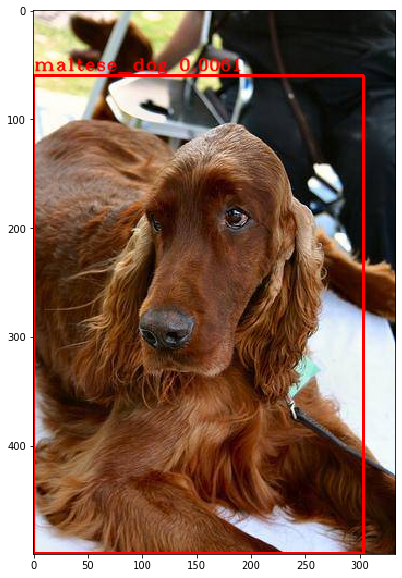

Predicted: no; time spent: 1.331688404083252 sec
Predicted: no; time spent: 1.252290964126587 sec
Predicted: no; time spent: 1.2622745037078857 sec
Predicted: entlebucher w. conf: 0.01189337857067585; time spent: 1.2493946552276611 sec


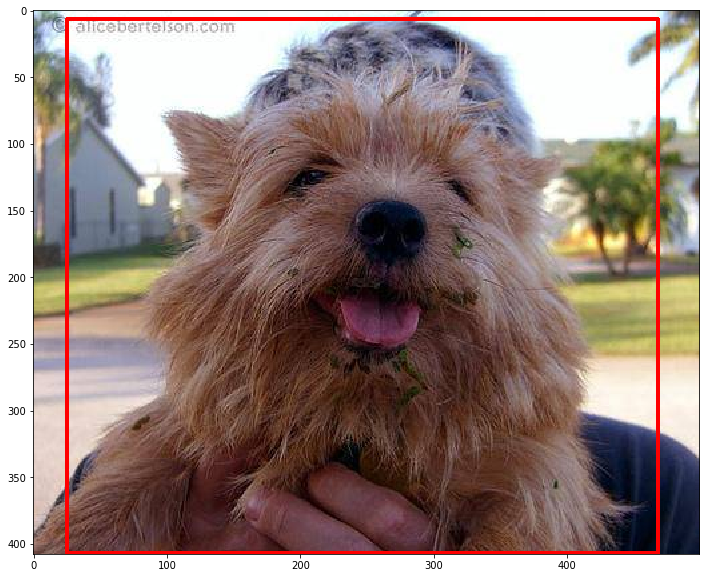

Predicted: scottish_deerhound w. conf: 0.005539375822991133; time spent: 1.3371009826660156 sec


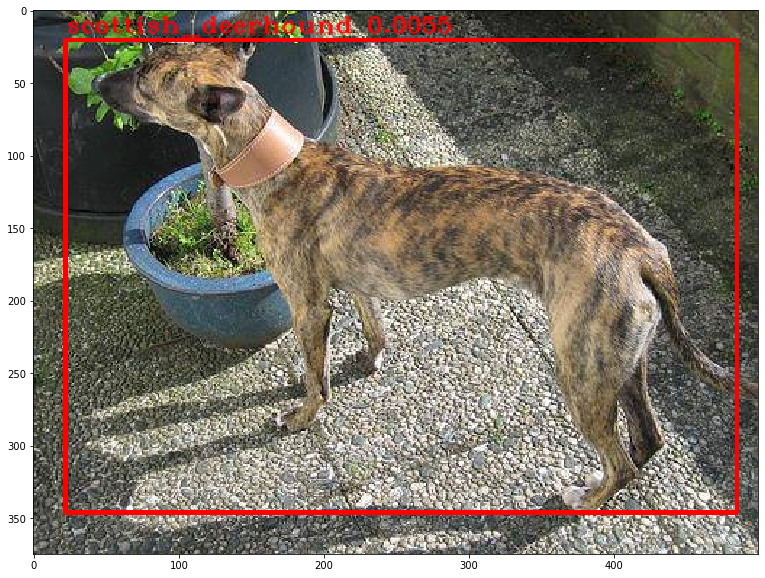

Predicted: entlebucher w. conf: 0.010883713141083717; time spent: 1.3683698177337646 sec


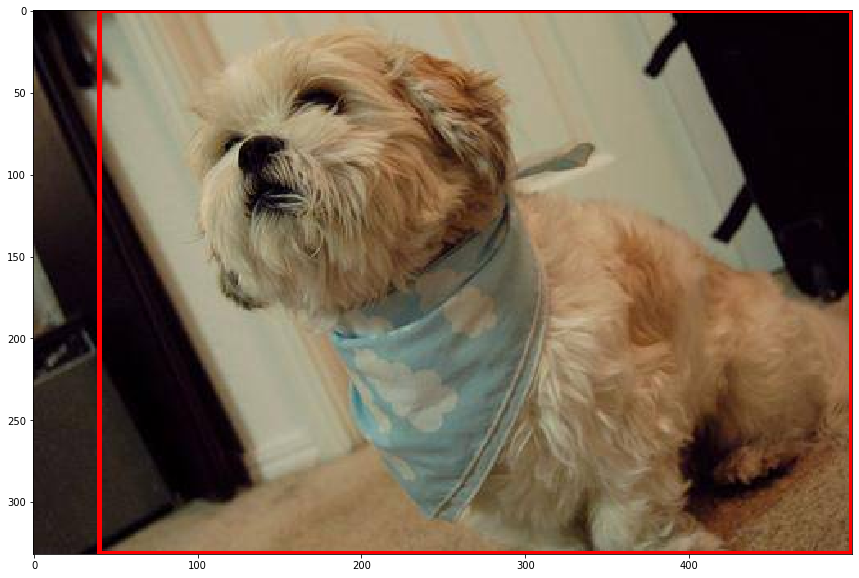

Predicted: entlebucher w. conf: 0.005379510577768087; time spent: 1.2989702224731445 sec


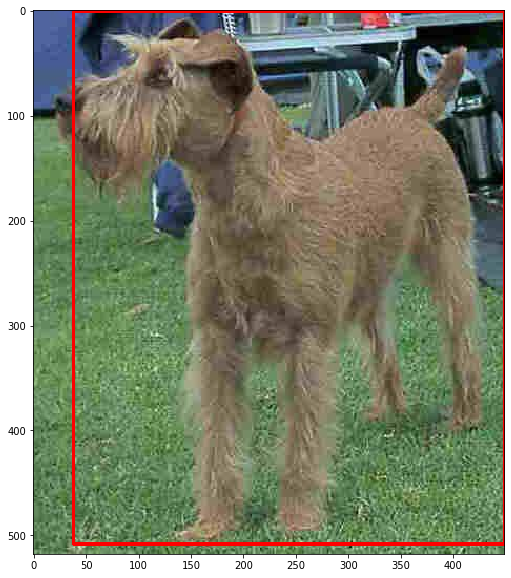

Predicted: no; time spent: 1.3163061141967773 sec
Predicted: no; time spent: 1.2436237335205078 sec
Predicted: irish_wolfhound w. conf: 0.01110429409891367; time spent: 1.2429230213165283 sec


In [0]:
path = 'dataset/test'
test_images = os.listdir(path)
found = 0

for img_path in test_images:
  path_to_img = f'{path}/{img_path}'
  image_ndarray = cv2.imread(path_to_img)
  image_ndarray = cv2.cvtColor(image_ndarray, cv2.COLOR_BGR2RGB)
  t = time.time()
  bbs = tfnet.return_predict(image_ndarray)
    
  pr = {}
  time_spent = time.time() - t
  max_conf = 0
  for predict in bbs:
    if (predict['confidence'] > max_conf):
      max_conf = predict['confidence']
      pr = predict
  if max_conf == 0:
    print(f'Predicted: no; time spent: {time_spent} sec')
  else:
    res = draw_bb(
        image_ndarray, 
        pr
    )
    
    label = pr['label']
    conf = pr['confidence']
    print(f'Predicted: {label} w. conf: {conf}; time spent: {time_spent} sec')
    fig_size = (20, 10)
    _, ax = plt.subplots(figsize = fig_size)
    ax.imshow(res)
    plt.show()